# Create basic analysis data

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from statistics import mode
import ast
import msmexplorer as msme
from msmbuilder.utils import load,dump
import itertools
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.featurizer import DihedralFeaturizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#XRD Ensemble
#28 4NPQ
#18 4HFI
import seaborn as sns

## Default values

In [2]:
default_location = '/home/scottzhuang/pdc/'
default_skip = 10

In [3]:
ensemble_location = '/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/'

In [4]:
subunit_dic = {0:0,1:1,2:2,3:3,4:4,5:0}

## Steps
1. Fix periodic boundary conditions (PBC) & choose a suitable timestep.
2. transform gro file into pdb file with chain information recovered.
3. create metadata
4. calculate RMSD, RMSF, PCA... & cluster
5. extract gating features & hydration data
6. extract HBond information of TMD
7. plotting Hbond mapping & elucidate important interactions
8. geometric features (dihedral angle...)
9. analysis data

In [5]:
traj_notes = ['4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6',
              '4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9',
              '5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3',
              '5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3',
              '4NPQ_pH70_md5','4NPQ_pH70_md6','4NPQ_pH70_md7']

### step1
using script **pre_fixing.sh**

### step2

### Step 3

In [28]:
def create_md_dataframe():    
    md_data = pd.DataFrame(columns=list(['MD_name','pH','replicate','subunit','traj_time']))
    return md_data

In [7]:
def create_metadata(md_data= None):   
    def append_metadata(traj_note, location = default_location, skip = default_skip, md_data = md_data):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if traj_note.find('ethanol') >= 0:
            print("In " + traj_note + ", simulation runs " + str(skip * traj.n_frames / 2 ) + " ns.")
        else:
            print("In " + traj_note + ", simulation runs " + str(skip * traj.n_frames) + " ns.")

        md_name = traj_note[:traj_note.find('pH')-1]
        pH = traj_note[traj_note.find('pH')+2:traj_note.find('pH')+4]
        md_replicate = traj_note[-1]
        for i in range(0,traj.n_frames):
            for subunit in range(0,5):
                md_data.loc[md_data.shape[0]+1] = [md_name,pH,md_replicate,subunit,i]

    for traj_note in traj_notes:
        append_metadata(traj_note)
    md_data['traj_time'] =md_data['traj_time'].apply(int)

In [8]:
def create_system_notation(md_data = None):
    system_notation = 0
    notation = -1
    location = default_location
    skip= default_skip

    notations = []
    increment = 0
    for traj_note in traj_notes:
        if traj_note.find('ethanol') >= 0:
            top_location = traj_note + '/' + traj_note + ".ca.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip*2) + ".ca.xtc"
        else:
            top_location = traj_note + '/' + traj_note + ".ca.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
#        if traj_note.find('md1') >= 0:
#            notation = notation + 1
#        if traj_note.find('md4') >= 0:
#            notation = notation + 1
#       if traj_note.find('md7') >= 0:
#            notation = notation + 1
        if traj_note in notation_changer:
            notation = notation + 1
            

        for frame in range(0,traj.n_frames):
            for subunit in range(0,5):
                notations.append(notation)
        #if increment % 3 == 2:
        #    notation = notation + 1
        #increment = increment + 1 
    md_data['system'] = notations

In [9]:
def create_rmsd_data(md_data= None, ref_name = None, select_domain = None):
    def append_rmsd_data(traj_note, subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        top_location = traj_note + '/' + traj_note + ".ca.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        traj = traj.atom_slice(traj.topology.select('chainid ' + str(subunit)))
        ref_location = location + top_location
        ref_traj = md.load(ref_location)
        ref_traj = ref_traj.atom_slice(ref_traj.topology.select('chainid ' + str(subunit)))
        traj.superpose(ref_traj,0)
        traj_rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        traj_rmsd_data = []

        for subunit in range(0,5):
            append_rmsd_data(traj_note,subunit)
        rmsd_data.extend(list(np.asarray(traj_rmsd_data).reshape(5,int(np.asarray(traj_rmsd_data).shape[0]/5)).T.ravel()))

    md_data['rmsd']= rmsd_data

In [38]:
def create_ecd_rmsd_data(md_data= None, ref_name = None, select_domain = 'ECD'):
    def append_rmsd_data(traj_note, subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        top_location = traj_note + '/' + traj_note + ".ca.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if select_domain == 'TMD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_1))
        traj = traj.atom_slice(traj.topology.select('chainid ' + str(subunit)))
        ref_location = location + top_location
        ref_traj = md.load(ref_location)
        ref_traj = ref_traj.atom_slice(ref_traj.topology.select('chainid ' + str(subunit)))
        if select_domain == 'TMD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_1))
        traj.superpose(ref_traj,0)
        traj_rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        traj_rmsd_data = []

        for subunit in range(0,5):
            append_rmsd_data(traj_note,subunit)
        rmsd_data.extend(list(np.asarray(traj_rmsd_data).reshape(5,int(np.asarray(traj_rmsd_data).shape[0]/5)).T.ravel()))
    if select_domain == 'TMD':
        md_data['tmd_rmsd']= rmsd_data
    elif select_domain == 'ECD':
        md_data['ecd_rmsd']= rmsd_data


In [39]:
def create_tmd_rmsd_data(md_data= None, ref_name = None, select_domain = 'TMD'):
    def append_rmsd_data(traj_note, subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        top_location = traj_note + '/' + traj_note + ".ca.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if select_domain == 'TMD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_1))
        traj = traj.atom_slice(traj.topology.select('chainid ' + str(subunit)))
        ref_location = location + top_location
        ref_traj = md.load(ref_location)
        ref_traj = ref_traj.atom_slice(ref_traj.topology.select('chainid ' + str(subunit)))
        if select_domain == 'TMD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_1))
        traj.superpose(ref_traj,0)
        traj_rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        traj_rmsd_data = []

        for subunit in range(0,5):
            append_rmsd_data(traj_note,subunit)
        rmsd_data.extend(list(np.asarray(traj_rmsd_data).reshape(5,int(np.asarray(traj_rmsd_data).shape[0]/5)).T.ravel()))
    if select_domain == 'TMD':
        md_data['tmd_rmsd']= rmsd_data
    elif select_domain == 'ECD':
        md_data['ecd_rmsd']= rmsd_data


In [10]:
def create_cppca_data(md_data = None): 
    def combined_ppca_reduced_cartesian():
        tmdtraj = md.load('/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/ensemble_subunit_tmd.pdb')
        ecdtraj = md.load('/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/ensemble_subunit_ecd.pdb')
        ppca_ecd = PCA(n_components=2)
        ppca_tmd = PCA(n_components=2)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(ecdtraj.xyz.reshape(ecdtraj.n_frames, ecdtraj.n_atoms * 3)), ppca_tmd.fit_transform(tmdtraj.xyz.reshape(tmdtraj.n_frames, tmdtraj.n_atoms * 3))]    
        print(ppca_ecd.explained_variance_ratio_)
        print(ppca_tmd.explained_variance_ratio_)
        return partial_reduced_cartesian, ecdtraj, tmdtraj,ppca_ecd,ppca_tmd

    def append_projection_on_combined_ppca_data(traj_note, subunit, location = default_location, skip = default_skip, residue_selection_1 = "resSeq 8 to 192", residue_selection_2 = "resSeq 192 to 315"):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1 + 'and chainid ' + str(subunit) ))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2 + 'and chainid ' + str(subunit) ))

        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,0)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,0)

        reduced_cartesian_ecd_pc1.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[0])
        reduced_cartesian_ecd_pc2.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[1])
        reduced_cartesian_tmd_pc1.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[0])
        reduced_cartesian_tmd_pc2.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[1])
        
    reduced_cartesian_ecd_pc1 = []
    reduced_cartesian_ecd_pc2 = []
    reduced_cartesian_tmd_pc1 = []
    reduced_cartesian_tmd_pc2 = []
    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian()

    for traj_note in traj_notes:
        for subunit in range(0,5):
            append_projection_on_combined_ppca_data(traj_note,subunit)
    md_data['ecd_pc1']= reduced_cartesian_ecd_pc1
    md_data['ecd_pc2']= reduced_cartesian_ecd_pc2
    md_data['tmd_pc1']= reduced_cartesian_tmd_pc1
    md_data['tmd_pc2']= reduced_cartesian_tmd_pc2

In [46]:
def create_helix_tilt_data(md_data = None):
    def append_helix_tilt_data(traj_note,subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        tilt_data = pd.read_csv(location + traj_note + '/analysis/' + traj_note + '.tilt.csv',sep=" ")
        tilt_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        traj_helix_tilt_data.extend(tilt_data['ang' + str(subunit+1)])

    helix_tilt_data = []
    for traj_note in traj_notes:
        traj_helix_tilt_data = []
        for subunit in range(0,5):
            append_helix_tilt_data(traj_note,subunit)
        helix_tilt_data.extend(list(np.asarray(traj_helix_tilt_data).reshape(5,int(np.asarray(traj_helix_tilt_data).shape[0]/5)).T.ravel()))

    md_data['helix tilt angle'] = helix_tilt_data

In [47]:
def create_helix_twist_data(md_data = None):
    def append_helix_twist_data(traj_note,subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        twist_data = pd.read_csv(location + traj_note + '/analysis/' + traj_note + '.twist.csv',sep=" ")
        twist_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        traj_helix_twist_data.extend(twist_data['ang' + str(subunit+1)])
        
    helix_twist_data = []
    for traj_note in traj_notes:
        traj_helix_twist_data = []

        for subunit in range(0,5):
            append_helix_twist_data(traj_note,subunit)
        helix_twist_data.extend(list(np.asarray(traj_helix_twist_data).reshape(5,int(np.asarray(traj_helix_twist_data).shape[0]/5)).T.ravel()))

    md_data['helix twist angle'] = helix_twist_data

In [13]:
def create_M1_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M1_kink_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M1_selection_up = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M1_selection_mid = 'resid ' + str(194 + chain * 311) + ' to ' + str(198 + chain * 311)
            M1_selection_down = 'resid ' + str(197 + chain * 311) + ' to ' + str(208 + chain * 311)

            M1_up = traj.atom_slice(topology.select(M1_selection_up))
            M1_mid = traj.atom_slice(topology.select(M1_selection_mid))
            M1_down = traj.atom_slice(topology.select(M1_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M1_up), md.compute_center_of_mass(M1_mid), md.compute_center_of_mass(M1_down)))
        M1_kink.extend(np.asarray(angle).T.ravel())
    M1_kink = []
    for traj_note in traj_notes:
        append_M1_kink_data(traj_note)
    md_data['M1_kink'] = M1_kink


In [14]:
def create_M2_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M2_kink_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M2_selection_up = 'resid ' + str(216 + chain * 311) + ' to ' + str(233 + chain * 311)
            M2_selection_mid = 'resid ' + str(233 + chain * 311) + ' to ' + str(233 + chain * 311)
            M2_selection_down = 'resid ' + str(233 + chain * 311) + ' to ' + str(240 + chain * 311)

            M2_up = traj.atom_slice(topology.select(M2_selection_up))
            M2_mid = traj.atom_slice(topology.select(M2_selection_mid))
            M2_down = traj.atom_slice(topology.select(M2_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M2_up), md.compute_center_of_mass(M2_mid), md.compute_center_of_mass(M2_down)))
        M2_kink.extend(np.asarray(angle).T.ravel())
    M2_kink = []
    for traj_note in traj_notes:
        append_M2_kink_data(traj_note)
    md_data['M2_kink'] = M2_kink


In [15]:
def create_hydration_profile_2(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
            top_location = traj_note + '/' + traj_note + ".system.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
            traj = mda.Universe(location + top_location,location + traj_location)
        else:
            top_location = traj_note + '/' + traj_note + ".system.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
            traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 8 -8 resid 236) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_236_center'] = hydration_data

In [16]:
def create_ethanol_profile(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
            top_location = traj_note + '/' + traj_note + ".system.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
            traj = mda.Universe(location + top_location,location + traj_location)
        else:
            top_location = traj_note + '/' + traj_note + ".system.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
            traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 10 -10 resid 235) and resname LIG",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['pore_ethanol_data'] = hydration_data

In [129]:
def plot():
    md_data = create_md_dataframe()
    create_metadata(md_data)
    create_system_notation(md_data)
    create_rmsd_data(md_data)
    create_ecd_rmsd_data(md_data)
    create_tmd_rmsd_data(md_data)

    create_cppca_data(md_data)

#    create_ecd_rmsd_data(md_data)
#    create_tmd_rmsd_data(md_data)
    create_helix_tilt_data(md_data)
    create_helix_twist_data(md_data)
    create_M1_kink(md_data)
    create_M2_kink(md_data)
#    create_pca_data(md_data)
#    create_hydration_profile_2(md_data)
#    create_ethanol_profile(md_data)
    for feature in md_data.columns[6:]:

        if len(set(md_data['system'])) == 2:
            fig, ax = plt.subplots(figsize=(15, 3))
            sns.violinplot(x='subunit',y=feature,hue='system',data=md_data,palette="muted", split=True,cut=0)
            fig.suptitle(notation_changer[list(set(md_data['system']))[0]] + ' vs ' + notation_changer[list(set(md_data['system']))[1]] + '_' + feature)

        else:
            for system in set(md_data['system']):
                for replicate in set(md_data[md_data.system == system]['replicate']):
                    fig, ax = plt.subplots(figsize=(15, 3))
                    sns.violinplot(x='subunit',y=feature,data=md_data[(md_data.system == system) & (md_data.replicate == replicate)],cut=0)
    #                color = np.random.rand(3,1)
                    fig.suptitle(notation_changer[system] + '_' + feature)
    #                group = md_data[(md_data.system == system)].groupby(['subunit'],sort=False)[feature]
    #                mean = group.mean()
    #                errors = group.sem()
    #                mean.plot.bar(yerr=errors,ax=ax)


In [120]:
import ptitprince as pt

In [121]:
sns.set(style="whitegrid",font_scale=1)
import matplotlib.collections as clt

In [142]:
def plot():
    md_data = create_md_dataframe()
    create_metadata(md_data)
    create_system_notation(md_data)
    create_rmsd_data(md_data)
    create_ecd_rmsd_data(md_data)
    create_tmd_rmsd_data(md_data)

    create_cppca_data(md_data)

#    create_ecd_rmsd_data(md_data)
#    create_tmd_rmsd_data(md_data)
    create_helix_tilt_data(md_data)
    create_helix_twist_data(md_data)
    create_M1_kink(md_data)
    create_M2_kink(md_data)
#    create_pca_data(md_data)
#    create_hydration_profile_2(md_data)
#    create_ethanol_profile(md_data)
    for feature in md_data.columns[6:]:

#            for system in set(md_data['system']):
#                for replicate in set(md_data[md_data.system == system]['replicate']):
        fig, ax = plt.subplots(figsize=(15, 3))
#                    sns.violinplot(x='subunit',y=feature,data=md_data[(md_data.system == system) & (md_data.replicate == replicate)])
        pt.RainCloud(x = 'system', y = feature, hue='subunit',data = md_data,  
                        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
#                color = np.random.rand(3,1)
        fig.suptitle(feature)
        ax.set_xticklabels(notation_changer)
    for feature in md_data.columns[6:]:

#            for system in set(md_data['system']):
#                for replicate in set(md_data[md_data.system == system]['replicate']):
        fig, ax = plt.subplots(figsize=(15, 3))
#                    sns.violinplot(x='subunit',y=feature,data=md_data[(md_data.system == system) & (md_data.replicate == replicate)])
        pt.RainCloud(x = 'system', y = feature, hue='replicate',data = md_data,  
                        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
#                color = np.random.rand(3,1)
        fig.suptitle(feature)
        ax.set_xticklabels(notation_changer)

    #                group = md_data[(md_data.system == system)].groupby(['subunit'],sort=False)[feature]
    #                mean = group.mean()
    #                errors = group.sem()
    #                mean.plot.bar(yerr=errors,ax=ax)


In 4NPQ_F238L_pH70_ethanol_md4, simulation runs 460.0 ns.
In 4NPQ_F238L_pH70_ethanol_md5, simulation runs 460.0 ns.
In 4NPQ_F238L_pH70_ethanol_md6, simulation runs 500.0 ns.
In 4NPQ_pH70_md8, simulation runs 730 ns.
In 4NPQ_pH70_md9, simulation runs 500 ns.
In 4NPQ_pH70_md10, simulation runs 540 ns.
In 4NPQ_F238L_pH70_md6, simulation runs 540 ns.
In 4NPQ_F238L_pH70_md7, simulation runs 500 ns.
In 4NPQ_F238L_pH70_md8, simulation runs 490 ns.
[ 0.53211844  0.21386905]
[ 0.67002475  0.20237753]


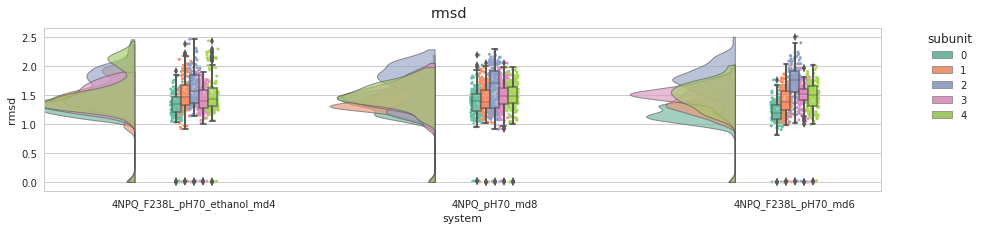

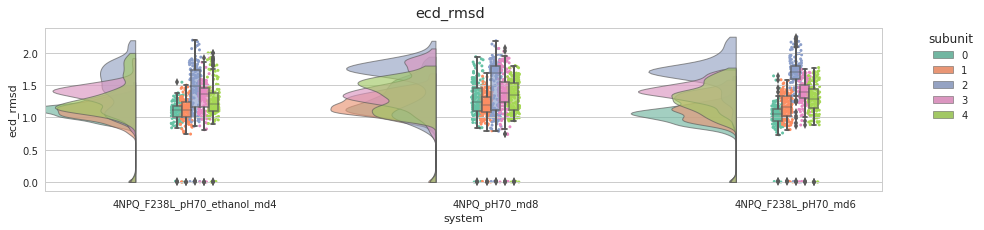

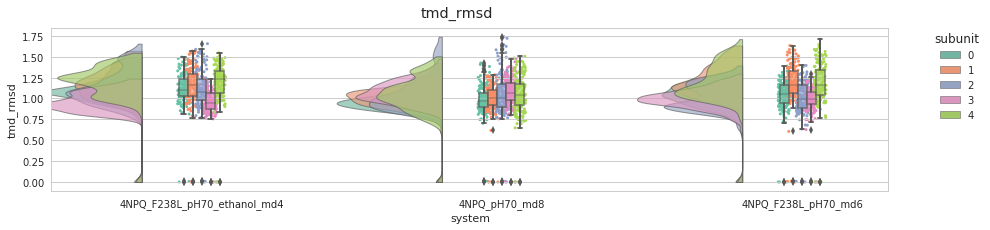

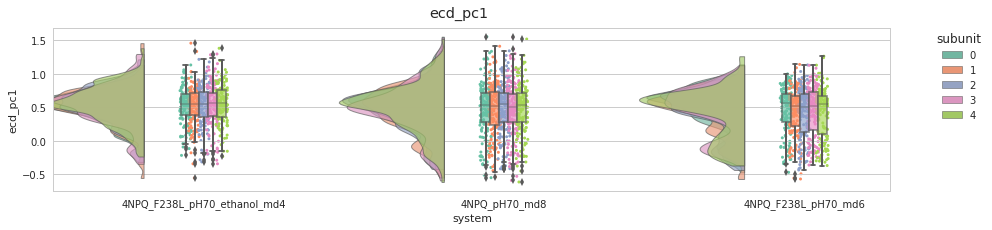

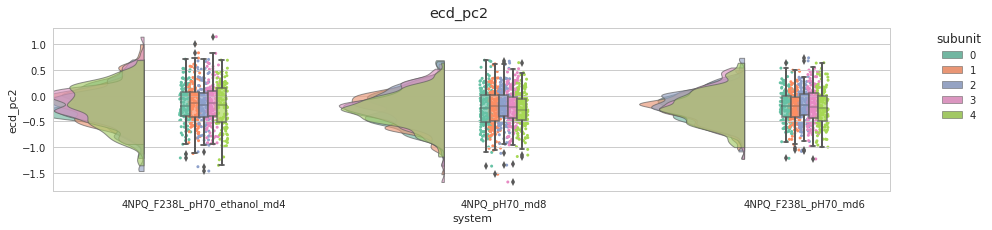

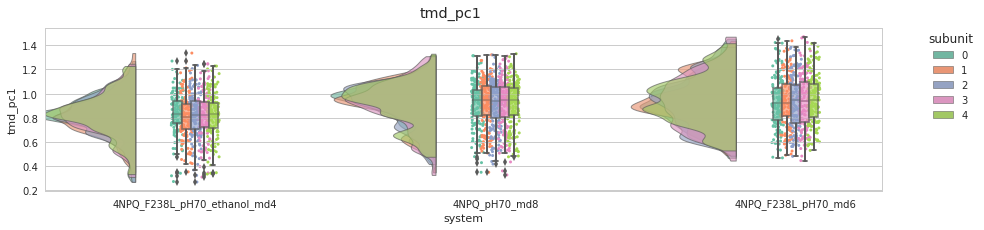

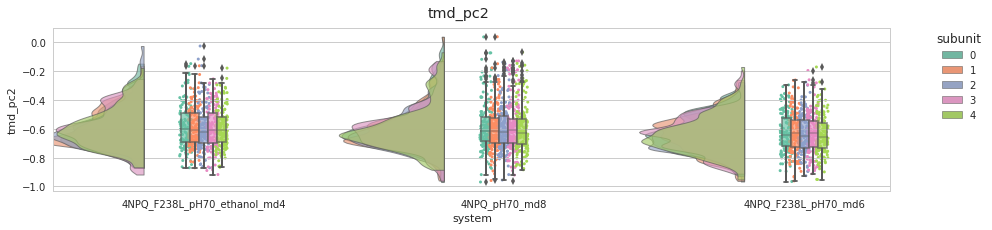

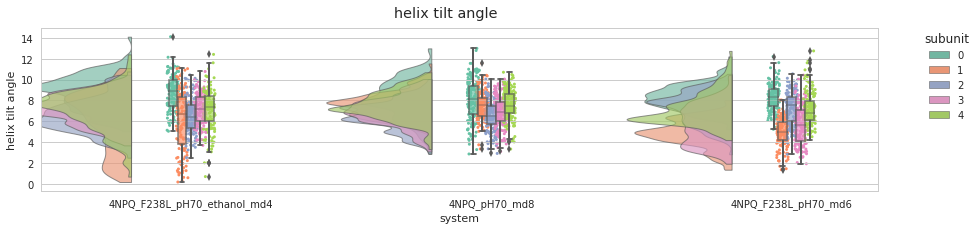

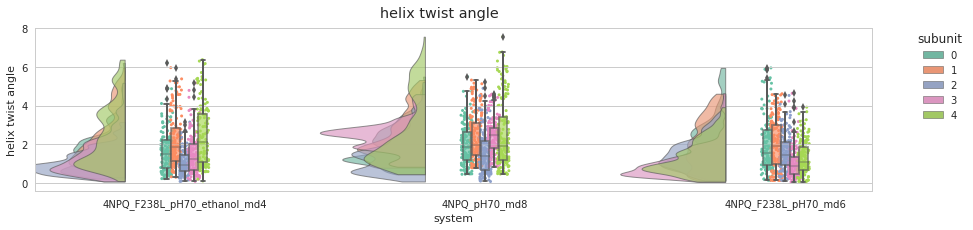

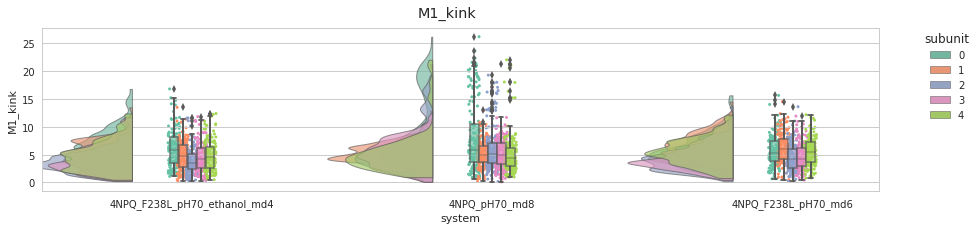

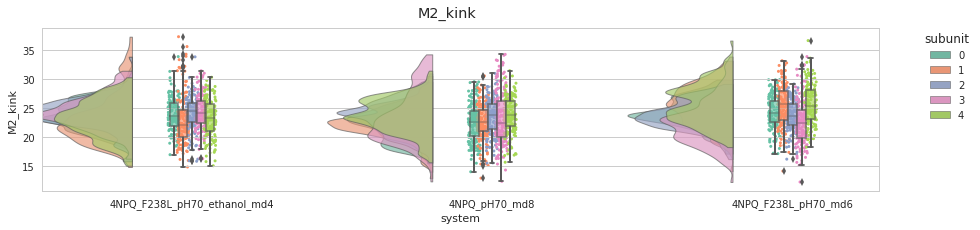

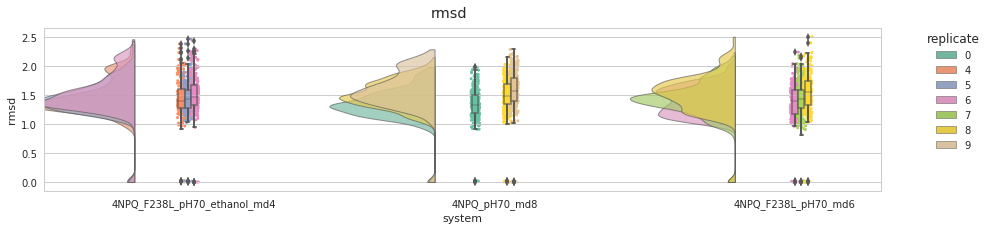

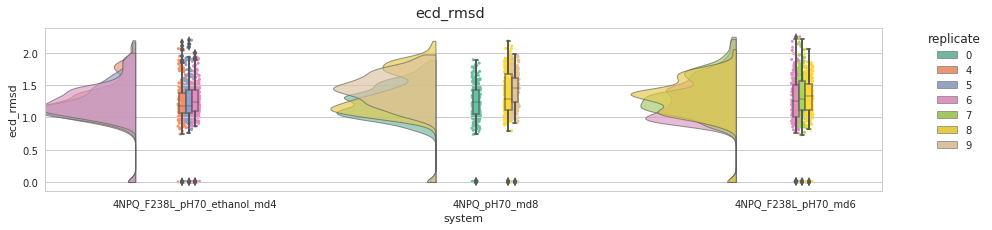

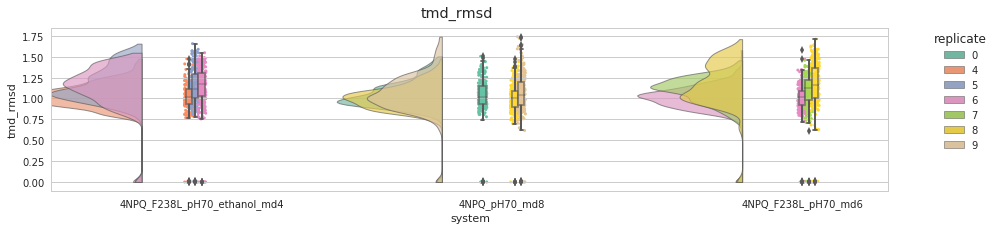

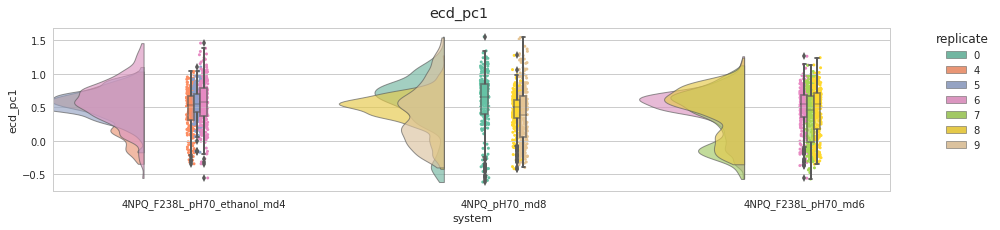

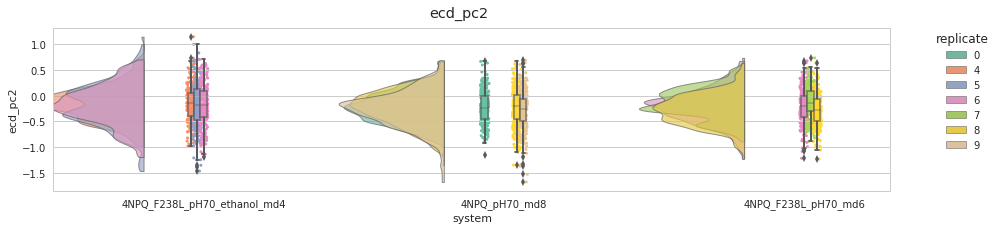

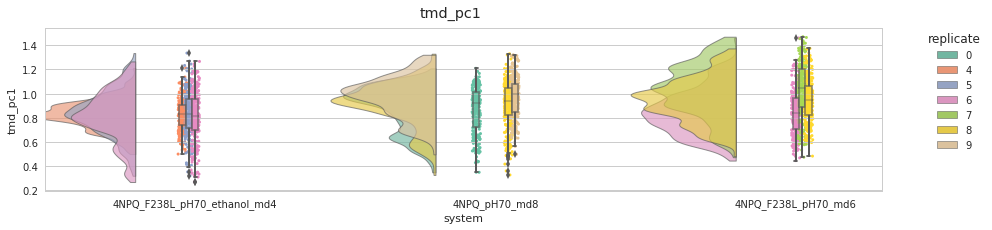

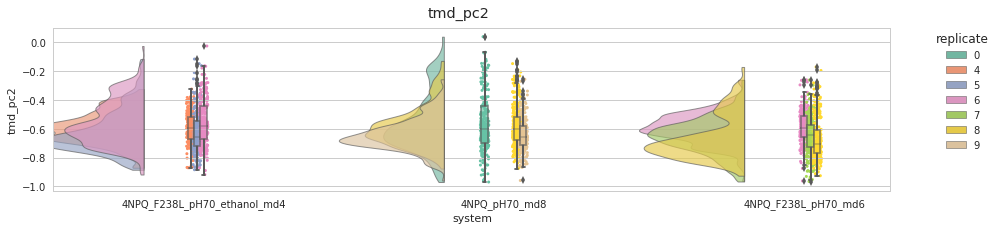

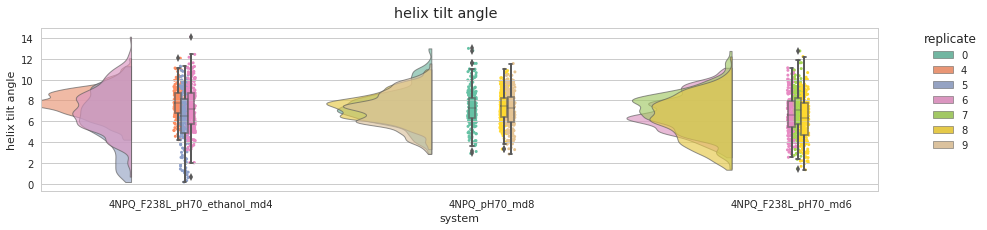

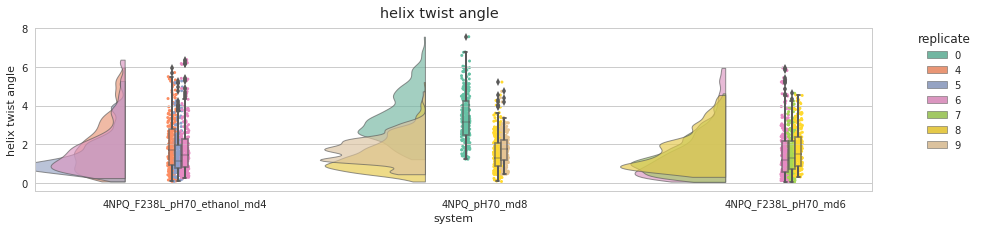

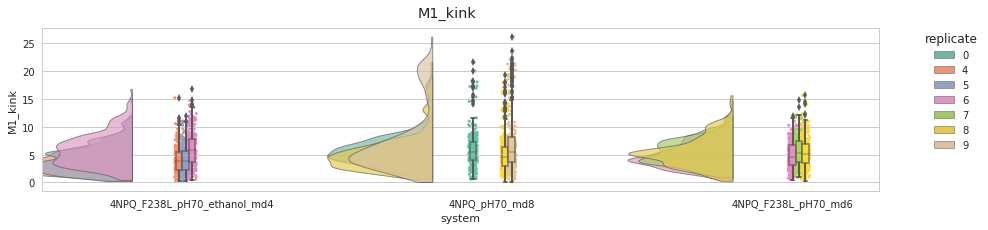

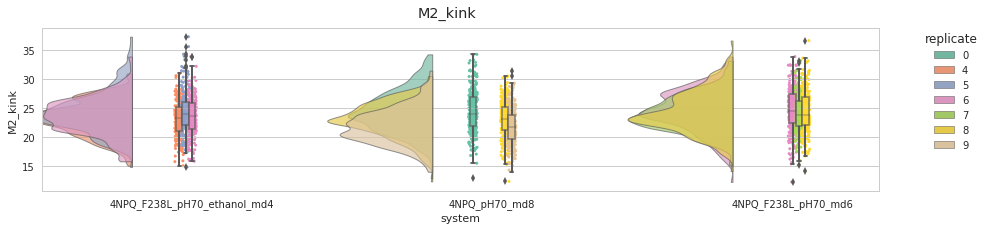

In [144]:
traj_notes =  [
              '4NPQ_F238L_pH70_ethanol_md4','4NPQ_F238L_pH70_ethanol_md5','4NPQ_F238L_pH70_ethanol_md6',
               '4NPQ_pH70_md8','4NPQ_pH70_md9','4NPQ_pH70_md10',
                '4NPQ_F238L_pH70_md6','4NPQ_F238L_pH70_md7','4NPQ_F238L_pH70_md8'
              ]
notation_changer = ['4NPQ_F238L_pH70_ethanol_md4','4NPQ_pH70_md8','4NPQ_F238L_pH70_md6']
default_location = '/home/scottzhuang/pdc/'
default_skip = 10
plot()